# Point Net Segmentation

This notebook will explore the Segmentation head of Point Net using the reduced and paritioned version of S3DIS dataset. This version is similar to the one used by torch geometry except that we will have to normalize and sample data on the fly. 

#### **Current State: Mildly Chaotic**

#### TODO:
- complete dataloader 
- Add functionality to unnormalize data
- complete test loop
- remove dataloader and place it in it's own .py script
- ensure that everything else is organized
- Continue training and testing
- Add descriptive analytics for dataset to help with understanding and training
- Add intuitive explainations and theory as needed
- Add test visualization portion once initial models are trained

TEMP NOTE

use "git reset HEAD~1" to go back one commit

https://stackoverflow.com/questions/20002557/how-to-remove-a-too-large-file-in-a-commit-when-my-branch-is-ahead-of-master-by

In [1]:
import os
import re
from glob import glob
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics.classification import MulticlassMatthewsCorrCoef
import open3d as o3
# from open3d import JVisualizer # For Colab Visualization
from open3d.web_visualizer import draw # for non Colab

import matplotlib.pyplot as plt
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
# TEMP for supressing pytorch user warnings
import warnings
warnings.filterwarnings("ignore")

Initialize variables for entire notebook

In [4]:
# dataset
ROOT = r'C:\Users\itber\Documents\datasets\S3DIS\Stanford3dDataset_v1.2_Reduced_Partitioned_Aligned_Version'
NUM_CLASSES = 14

# feature selection hyperparameters
NUM_TRAIN_POINTS = 4096 # train/valid points
NUM_TEST_POINTS = 10000

# training hyperparameters
BATCH_SIZE = 16
EPOCHS = 25
LR = 0.01

In [38]:
CATEGORIES = {
    'ceiling'  : 0, 
    'floor'    : 1, 
    'wall'     : 2, 
    'beam'     : 3, 
    'column'   : 4, 
    'window'   : 5,
    'door'     : 6, 
    'table'    : 7, 
    'chair'    : 8, 
    'sofa'     : 9, 
    'bookcase' : 10, 
    'board'    : 11,
    'stairs'   : 12,
    'clutter'  : 13
}

# unique color map generated via
# https://mokole.com/palette.html
COLOR_MAP = {
    0  : (47, 79, 79),    # ceiling - darkslategray
    1  : (139, 69, 19),   # floor - saddlebrown
    2  : (34, 139, 34),   # wall - forestgreen
    3  : (75, 0, 130),    # beam - indigo
    4  : (255, 0, 0),     # column - red 
    5  : (255, 255, 0),   # window - yellow
    6  : (0, 255, 0),     # door - lime
    7  : (0, 255, 255),   # table - aqua
    8  : (0, 0, 255),     # chair - blue
    9  : (255, 0, 255),   # sofa - fuchsia
    10 : (238, 232, 170), # bookcase - palegoldenrod
    11 : (100, 149, 237), # board - cornflower
    12 : (255, 105, 180), # stairs - hotpink
    13 : (0, 0, 0)        # clutter - black
}

v_map_colors = np.vectorize(lambda x : COLOR_MAP[x])

#### Get Datasets and Dataloaders

In [7]:
from torch.utils.data import DataLoader
from s3dis_dataset import S3DIS

# get datasets
s3dis_train = S3DIS(ROOT, area_nums='1-4', npoints=NUM_TRAIN_POINTS)
s3dis_valid = S3DIS(ROOT, area_nums='5', npoints=NUM_TRAIN_POINTS)
s3dis_test = S3DIS(ROOT, area_nums='6', split='test', npoints=NUM_TEST_POINTS)

# get dataloaders
train_dataloader = DataLoader(s3dis_train, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(s3dis_valid, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(s3dis_test, batch_size=BATCH_SIZE, shuffle=False)

Get an example and display it

In [7]:
points, targets = s3dis_train[1000]

pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points)
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(targets)).T/255)

draw(pcd)

WebVisualizer(window_uid='window_0')

#### Investigate class distributions in the Training dataset

In [32]:
total_targets = []
for (points, targets) in train_dataloader:
    total_targets += targets.reshape(-1).numpy().tolist()

total_targets = np.array(total_targets)

Plot Barchart of category counts

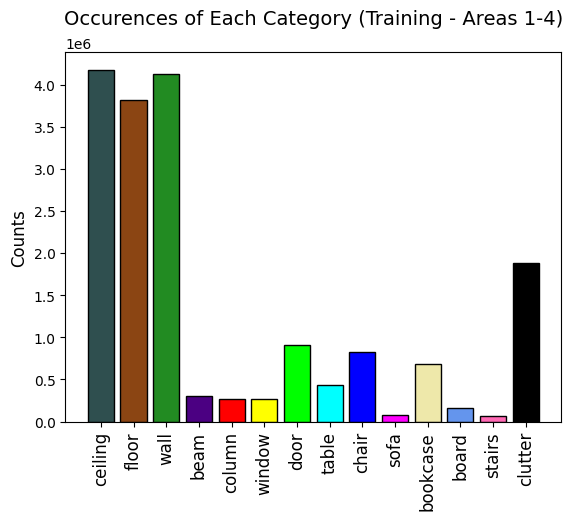

In [78]:
class_bins = np.bincount(total_targets)

plt.bar(list(CATEGORIES.keys()), class_bins, 
             color=[np.array(val)/255. for val in list(COLOR_MAP.values())],
             edgecolor='black')
plt.xticks(list(CATEGORIES.keys()), list(CATEGORIES.keys()), size=12, rotation=90)
plt.ylabel('Counts', size=12)
plt.title('Occurences of Each Category (Training - Areas 1-4)', size=14, pad=20);

We can see that this dataset is heavily imbalanced, the more common items such as ceiling, floor, and wall greatly outnumber all of the other categories. These classes are actually background classes. If we were to train using a loss such as Cross Entropy, we would consider each class to have an equal importance. Meaning, missclassifyng window is trreated the same as misclassifying wall. In reality, we would want our model to focus more on the uncommon categories and not care so much about the common ones. We have a priori knowledge that structures such as ceiling, wall, and floor are continuous and if we look at some training examples, we will see that they are like large sheets. If we were to only classify 60% of these, we would still be in pretty good shape. However, if we classify only 60% of the other less common classes, we may run into some serious generalization issues. One way to overcome the class imbalance is to use a weighted loss function. This will essentially tell the model (during training) to focus more on particular classes that it gets wrong (hard examples) and to focus less on the classes it tends to get right (easy examples).

*SIDE NOTE:*
*With the notion that certain classes have unique structures, it may be more effective to perform object recognition as opposed to segmentation. Or use some sort of object recognition to augment the segmentation model and form some sort of ensemble.*

The loss that we will use is called the [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf), it is a modified version of the Cross Entropy (CE) loss that is usefule for imbalanced classification

### Get Segmentation Version of Point Net
Make a test forward pass

In [8]:
points, targets = next(iter(train_dataloader))
points.shape

torch.Size([16, 4096, 3])

In [9]:
from point_net import PointNetSegHead

seg_model = PointNetSegHead(num_points=NUM_TRAIN_POINTS, m=NUM_CLASSES)
out, _, _ = seg_model(points.transpose(2, 1))
print(f'Seg shape: {out.shape}')

Seg shape: torch.Size([16, 4096, 14])


## Start Training

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

We will use a pytorch implementation of the focal loss from this [repository](https://github.com/clcarwin/focal_loss_pytorch/blob/master/focalloss.py)

In [112]:
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float, int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,(list, np.ndarray)): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [113]:
points.shape

torch.Size([10, 3, 10000])

In [114]:
targets.shape

torch.Size([10, 10000])

Compute $\alpha$ as the normalized inverse class frequency

In [115]:
alpha = 1 / class_bins
alpha = (alpha/alpha.max()) - 1e-4
alpha

array([0.01697265, 0.01858493, 0.01720927, 0.23992475, 0.2716861 ,
       0.26652981, 0.07832637, 0.16263879, 0.08603886, 0.9198402 ,
       0.10384929, 0.44059073, 0.9999    , 0.0378202 ])

In [125]:
criterion = FocalLoss(gamma=2, alpha=alpha)

In [134]:
criterion(preds.transpose(2, 1), targets)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [129]:
preds.transpose(2, 1).shape

torch.Size([10, 14, 10000])

In [135]:
a = 123

In [128]:
targets.shape

torch.Size([10, 10000])

In [132]:
preds

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [131]:
torch.log_softmax(preds)

TypeError: log_softmax() received an invalid combination of arguments - got (Tensor), but expected one of:
 * (Tensor input, int dim, torch.dtype dtype)
 * (Tensor input, name dim, *, torch.dtype dtype)


In [11]:
import torch.nn as nn 
import torch.optim as optim
if torch.cuda.is_available():
    import torch.backends.cudnn as cudnn

optimizer = optim.Adam(seg_model.parameters(), lr=0.01)
criterion = FocalLoss(gamma=2, alpha=)

seg_model = seg_model.to(device)

For our training we will want to quantify how well our model is performing. Typically we look at loss and accuracy, but for this segmentation problem we will need a mteric that accounts for incorrect classifcation as well as correct classification. The Matthews Correlation Coefficent does this and we will use it to quantify our performance. The MCC ranges from -1 to 1, to understand what the MCC is reporting:
- 0 indicates a random guess
- -1 is the worst possible performance
- 1 is the best possible performance

In [12]:
mcc_metric = MulticlassMatthewsCorrCoef(num_classes=NUM_CLASSES).to(device)

In [153]:
# stuff for training
num_train_batch = len(s3dis_train)/BATCH_SIZE 
num_valid_batch = len(s3dis_valid)/BATCH_SIZE 

# lists to store metrics
train_loss = []
train_accuracy = []
train_mcc = []
valid_loss = []
valid_accuracy = []
valid_mcc = []

for epoch in range(1, EPOCHS + 1):
    # place model in training mode
    seg_model = seg_model.train()
    _train_loss = []
    _train_accuracy = []
    _train_mcc = []
    for i, (points, targets) in enumerate(train_dataloader, 0):

        points = points.transpose(2, 1).to(device)
        targets = targets.squeeze().to(device)
        
        # zero gradients
        optimizer.zero_grad()
        
        # get predicted class logits
        preds, _, A = seg_model(points)
        
        # compute regularization term to enforce orthogonality on the feature Transformation
        # I = torch.eye(64).unsqueeze(0).repeat(A.shape[0], 1, 1).to(device)
        # reg = torch.linalg.norm(I - torch.bmm(A, A.transpose(2, 1)))

        # get loss and perform backprop
        loss = criterion(preds.transpose(2, 1), targets) # + reg
        loss.backward()
        optimizer.step()
        
        # get class predictions
        pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct/float(BATCH_SIZE*NUM_TRAIN_POINTS)
        mcc = mcc_metric(preds.transpose(2, 1), targets)

        # update epoch loss and accuracy
        _train_loss.append(loss.item())
        _train_accuracy.append(accuracy)
        _train_mcc.append(mcc.item())

        if i % 100 == 0:
            print('\t [%d: %d/%d] train loss: %f accuracy: %f mcc: %f' \
                  % (epoch, i, num_train_batch, loss.item(), accuracy, mcc))
        
    train_loss.append(np.mean(_train_loss))
    train_accuracy.append(np.mean(_train_accuracy))
    train_mcc.append(np.mean(_train_mcc))

    print(f'Epoch: {epoch} - Train Loss: {train_loss[-1]} ' \
          + f'- Train Accuracy: {train_accuracy[-1]} ' \
          + f'- Train MCC: {train_mcc[-1]}')

    # pause to cool down
    time.sleep(4)

    # get test results after each epoch
    with torch.no_grad():

        # place model in evaluation mode
        seg_model = seg_model.eval()

        _valid_loss = []
        _valid_accuracy = []
        _valid_mcc = []
        for i, (points, targets) in enumerate(valid_dataloader, 0):

            points = points.transpose(2, 1).to(device)
            targets = targets.squeeze().to(device)

            preds, _, A = seg_model(points)

            # compute regularization term to enforce orthogonality on the feature Transformation
            # I = torch.eye(64).unsqueeze(0).repeat(A.shape[0], 1, 1).to(device)
            # reg = torch.linalg.norm(I - torch.bmm(A, A.transpose(2, 1)))

            loss = criterion(preds.transpose(2, 1), targets) # + reg

            pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)
            correct = pred_choice.eq(targets.data).cpu().sum()
            accuracy = correct/float(BATCH_SIZE*NUM_TRAIN_POINTS)
            mcc = mcc_metric(preds.transpose(2, 1), targets)

            # update epoch loss and accuracy
            _valid_loss.append(loss.item())
            _valid_accuracy.append(accuracy)
            _valid_mcc.append(mcc.item())

            if i % 100 == 0:
                print('\t [%d: %d/%d] %s loss: %f accuracy: %f mcc: %f' \
                      % (epoch, i, num_valid_batch, 'validation', loss.item(), accuracy, mcc))
        
        valid_loss.append(np.mean(_valid_loss))
        valid_accuracy.append(np.mean(_valid_accuracy))
        valid_mcc.append(np.mean(_valid_mcc))
        print(f'Epoch: {epoch} - Validation Loss: {valid_loss[-1]} ' \
              + f'- Validation Accuracy: {valid_accuracy[-1]} ' \
              + f'- Validation MCC: {valid_mcc[-1]}')

        # pause to cool down
        time.sleep(4)
    # TEMP
    # print(STOP)

    torch.save(seg_model.state_dict(), f'seg_noreg/seg_model_{epoch}.pth')

	 [1: 0/274] train loss: 2.708304 accuracy: 0.123093 mcc: 0.046623
	 [1: 100/274] train loss: 1.186648 accuracy: 0.639877 mcc: 0.553613
	 [1: 200/274] train loss: 1.023315 accuracy: 0.718338 mcc: 0.646939
Epoch: 1 - Train Loss: 1.3292566804452377 - Train Accuracy: 0.5940490365028381 - Train MCC: 0.5059658076478676
	 [1: 0/145] validation loss: 2306.324951 accuracy: 0.571732 mcc: 0.491121
	 [1: 100/145] validation loss: 0.983163 accuracy: 0.739349 mcc: 0.670588
Epoch: 1 - Validation Loss: 16.933285278000245 - Validation Accuracy: 0.6454542875289917 - Validation MCC: 0.5735057061665678
	 [2: 0/274] train loss: 1.170918 accuracy: 0.607986 mcc: 0.507224
	 [2: 100/274] train loss: 1.052689 accuracy: 0.659378 mcc: 0.585153
	 [2: 200/274] train loss: 1.047759 accuracy: 0.704025 mcc: 0.636710
Epoch: 2 - Train Loss: 1.1012760825590653 - Train Accuracy: 0.6609679460525513 - Train MCC: 0.5937104464660992
	 [2: 0/145] validation loss: 1.156446 accuracy: 0.642670 mcc: 0.552939
	 [2: 100/145] valida

Let's plot the training metrics

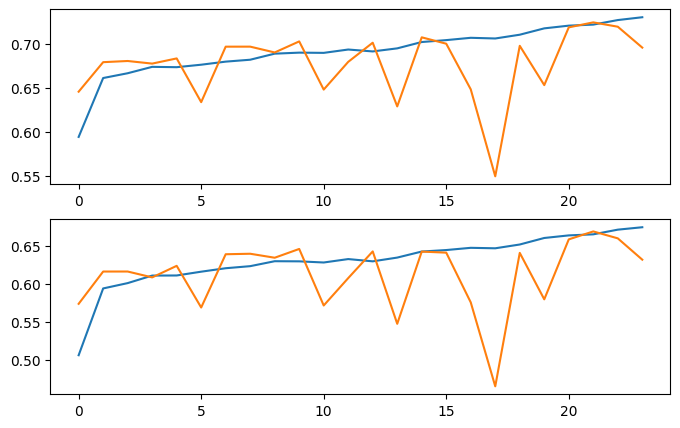

In [166]:
_, ax = plt.subplots(2, 1, figsize=(8, 5))
ax[0].plot(train_accuracy)
ax[0].plot(valid_accuracy)

ax[1].plot(train_mcc)
ax[1].plot(valid_mcc)

In [168]:
np.argmax(valid_mcc)

21

### Test the model

Upload model from disk. The best model was 21 (actually 22 since we need to account for zero indexing)

In [19]:
MODEL_PATH = 'seg_noreg/seg_model_22.pth'

model = PointNetSegHead(num_points=NUM_TEST_POINTS, m=NUM_CLASSES).to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval();

#### Implement Quick test to gather metrics

In [63]:
num_test_batch = len(s3dis_test)/BATCH_SIZE 

total_test_targets = []
total_test_preds = [] 

with torch.no_grad():

    # place model in evaluation mode
    model = model.eval()

    test_loss = []
    test_accuracy = []
    test_mcc = []
    for i, (points, targets) in enumerate(test_dataloader, 0):

        points = points.transpose(2, 1).to(device)
        targets = targets.squeeze().to(device)

        preds, _, A = model(points)

        # compute regularization term to enforce orthogonality on the feature Transformation
        # I = torch.eye(64).unsqueeze(0).repeat(A.shape[0], 1, 1).to(device)
        # reg = torch.linalg.norm(I - torch.bmm(A, A.transpose(2, 1)))

        loss = criterion(preds.transpose(2, 1), targets) # + reg

        pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct/float(BATCH_SIZE*NUM_TEST_POINTS)
        mcc = mcc_metric(preds.transpose(2, 1), targets)

        # update epoch loss and accuracy
        test_loss.append(loss.item())
        test_accuracy.append(accuracy)
        test_mcc.append(mcc.item())

        # add to total targets/preds
        total_test_targets += targets.reshape(-1).cpu().numpy().tolist()
        total_test_preds += pred_choice.reshape(-1).cpu().numpy().tolist()

        if i % 50 == 0:
            print('\t [%d/%d] test loss: %f accuracy: %f mcc: %f' \
                    % (i, num_test_batch, loss.item(), accuracy, mcc))

# display test results
print(f'Test Loss: {np.mean(test_loss)} ' \
        + f'- Test Accuracy: {np.mean(test_accuracy)} ' \
        + f'- Test MCC: {np.mean(test_mcc)}')

	 [0/71] test loss: 16297419776.000000 accuracy: 0.529037 mcc: 0.477067
	 [50/71] test loss: 24418680832.000000 accuracy: 0.583319 mcc: 0.518947
Test Loss: 42981061871.48179 - Test Accuracy: 0.5650807619094849 - Test MCC: 0.49528303204311264


In [64]:
total_test_targets = np.array(total_test_targets)
total_test_preds = np.array(total_test_preds)

#### Get Confusion Matrix for Test data

In [69]:
from sklearn.metrics import confusion_matrix

test_confusion = pd.DataFrame(confusion_matrix(total_test_targets, total_test_preds),
                              columns=list(CATEGORIES.keys()),
                              index=list(CATEGORIES.keys()))

test_confusion

,ceiling,floor,wall,beam,column,window,door,table,chair,sofa,bookcase,board,stairs,clutter
ceiling,1978676,16600,51767,6683,103,9154,0,2113,3585,0,125,0,17323,415292
floor,6136,1947107,7250,0,0,0,0,0,348,0,0,0,13332,211651
wall,33441,50190,1255620,74884,1372,53651,269,28264,41413,6,45726,0,21789,805983
beam,28107,610,70957,305650,0,0,76,872,0,0,285,0,2505,59259
column,900,7018,282961,2016,2812,15610,0,506,305,0,1555,0,0,16381
window,1595,4000,70702,0,0,85453,0,4835,363,6,501,0,7338,60756
door,56,15658,499988,48332,0,0,4782,1028,5804,0,5692,0,298,27684
table,3114,14332,20994,0,0,582,0,76157,109989,0,4187,0,1358,287563
chair,79,31587,21664,0,0,23,0,9038,316191,0,779,0,37,63695
sofa,0,5511,2600,0,0,0,0,514,27305,0,194,0,0,11806


#### View test results on full space

In [ ]:
torch.cuda.empty_cache() # release GPU memory
points, targets = s3dis_test.get_random_partitioned_space()

# place on device
points = points.to(device)
targets = targets.to(device)

# Normalize each partitioned Point Cloud to (0, 1)
norm_points = points.clone()
norm_points = norm_points - norm_points.min(axis=1)[0].unsqueeze(1)
norm_points /= norm_points.max(axis=1)[0].unsqueeze(1)

with torch.no_grad():

    norm_points = norm_points.transpose(2, 1)
    targets = targets.squeeze()

    preds, _, A = model(norm_points)

    pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)
    correct = pred_choice.eq(targets.data).cpu().sum()
    accuracy = correct/float(points.shape[0]*NUM_TEST_POINTS)
    mcc = mcc_metric(preds.transpose(2, 1), targets)

Display the truth and predictions

In [22]:
pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points.permute(2, 0, 1).reshape(3, -1).to('cpu').T)
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(targets.reshape(-1).to('cpu'))).T/255)

draw(pcd)

WebVisualizer(window_uid='window_4')

In [17]:
pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points.to('cpu')[2, :, :])
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(targets.to('cpu')[2, :])).T/255)

draw(pcd)

WebVisualizer(window_uid='window_2')

In [23]:
pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points.permute(2, 0, 1).reshape(3, -1).to('cpu').T)
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(pred_choice.reshape(-1).to('cpu'))).T/255)

draw(pcd)

WebVisualizer(window_uid='window_5')

In [18]:
pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points.to('cpu')[2, :, :])
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(pred_choice.to('cpu')[2, :])).T/255)

draw(pcd)

WebVisualizer(window_uid='window_3')

### General Notes

It appears that not using the regularized loss leads to quicker training i.e. better performance with less epochs. Some more experimentation could be done to check if the regularization leads to superior performance over a longer training period.